In [19]:
#  Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [37]:
# Define transformations for dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),       # Convert images to PyTorch tensors
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Extract class labels
classes = dataset.classes  # CIFAR-10 has 10 classes

Files already downloaded and verified


In [38]:
# Defining the generator model for conditional image generation
class NumberConditionalGenerator(nn.Module):
    def __init__(self):
        super(NumberConditionalGenerator, self).__init__()
        self.embedding_layer = nn.Embedding(10, 100)  # Embedding layer for number conditions

        self.model = nn.Sequential(
            nn.Linear(200, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # 3 channels for color images
            nn.Tanh()
        )

    def forward(self, noise, numbers):
        embedded_numbers = self.embedding_layer(numbers)
        combined_input = torch.cat((noise, embedded_numbers), dim=1)
        generated_image = self.model(combined_input)
        return generated_image.view(generated_image.size(0), 3, 32, 32)

In [33]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the generator
generator = NumberConditionalGenerator().to(device)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch_index, (real_images, labels) in enumerate(dataloader):
        real_images, labels = real_images.to(device), labels.to(device)
        random_noise = torch.randn(labels.size(0), 100).to(device)

        optimizer.zero_grad()
        fake_images = generator(random_noise, labels)

        loss = loss_function(fake_images, real_images)
        loss.backward()
        optimizer.step()

        if (batch_index + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_index+1}/{len(color_dataloader)}], Loss: {loss.item():.4f}")

Epoch [1/50], Step [100/782], Loss: 0.0648
Epoch [1/50], Step [200/782], Loss: 0.0614
Epoch [1/50], Step [300/782], Loss: 0.0577
Epoch [1/50], Step [400/782], Loss: 0.0598
Epoch [1/50], Step [500/782], Loss: 0.0543
Epoch [1/50], Step [600/782], Loss: 0.0572
Epoch [1/50], Step [700/782], Loss: 0.0650
Epoch [2/50], Step [100/782], Loss: 0.0605
Epoch [2/50], Step [200/782], Loss: 0.0542
Epoch [2/50], Step [300/782], Loss: 0.0643
Epoch [2/50], Step [400/782], Loss: 0.0601
Epoch [2/50], Step [500/782], Loss: 0.0643
Epoch [2/50], Step [600/782], Loss: 0.0690
Epoch [2/50], Step [700/782], Loss: 0.0614
Epoch [3/50], Step [100/782], Loss: 0.0661
Epoch [3/50], Step [200/782], Loss: 0.0592
Epoch [3/50], Step [300/782], Loss: 0.0593
Epoch [3/50], Step [400/782], Loss: 0.0577
Epoch [3/50], Step [500/782], Loss: 0.0528
Epoch [3/50], Step [600/782], Loss: 0.0477
Epoch [3/50], Step [700/782], Loss: 0.0527
Epoch [4/50], Step [100/782], Loss: 0.0611
Epoch [4/50], Step [200/782], Loss: 0.0582
Epoch [4/50

In [40]:
# Define a conditional image generator
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(10, 100)  # Embedding for condition (numbers 0-9)

        self.model = nn.Sequential(
            nn.Linear(200, 256),  # Combine noise and condition embedding
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # Output for 3 color channels
            nn.Tanh()  # Normalize output between -1 and 1
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)  # Convert labels to embedding
        combined_input = torch.cat((noise, label_input), dim=-1)  # Concatenate noise and condition
        output = self.model(combined_input)
        return output.view(output.size(0), 3, 32, 32)  # Reshape to (batch_size, 3, 32, 32)

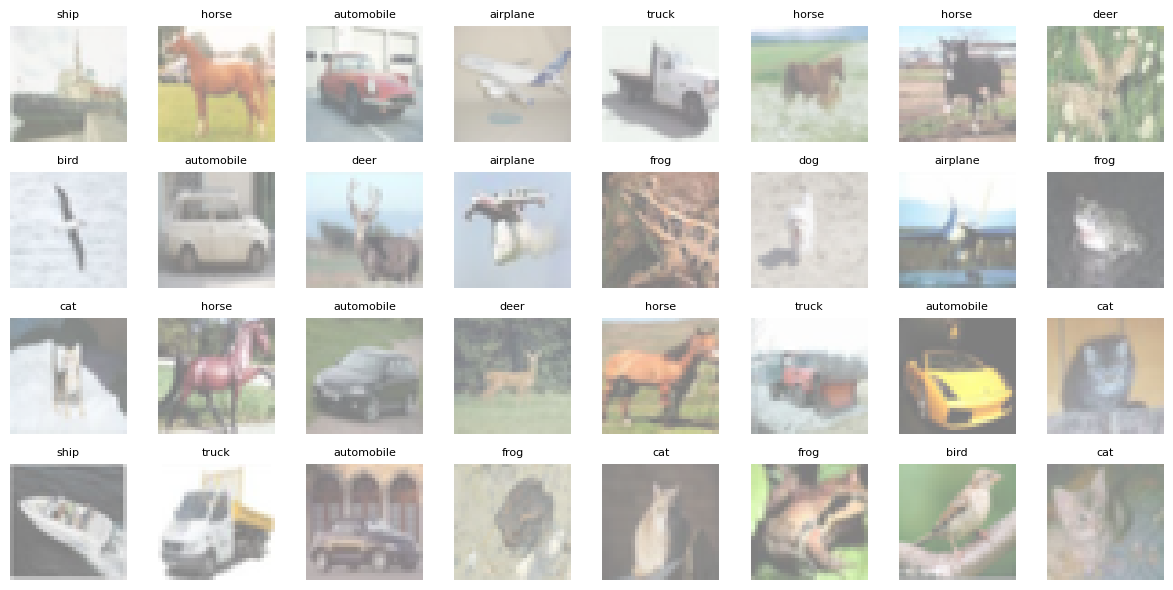

In [41]:
# Fetch a batch of images and labels
images, labels = next(iter(dataloader))
images = images.numpy()  # Convert to NumPy for visualization

# Plot the images
fig, axes = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    img = images[i].transpose(1, 2, 0)  # Convert to HWC format
    ax.imshow((img * 0.5 + 0.5))  # Normalize pixel values for display
    ax.set_title(classes[labels[i]], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Generate conditional images using the model
def generate_images(generator, condition, num_samples=8):
    """
    Generates images conditioned on a numeric label.
    Args:
        generator (nn.Module): The trained generator model.
        condition (int): The class index (0-9) to condition the generation.
        num_samples (int): Number of images to generate.
    Returns:
        torch.Tensor: Generated images.
    """
    generator.eval()  # Set the generator to evaluation mode

    # Create random noise and labels
    noise = torch.randn(num_samples, 100)  # Random noise
    labels = torch.tensor([condition] * num_samples)  # Numeric condition

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise, labels)

    # Rescale images to [0, 1] for visualization
    generated_images = (generated_images * 0.5 + 0.5).clamp(0, 1)
    return generated_images

In [50]:
# Define a simple discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32 + 100, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, images, labels):
        labels_input = nn.Embedding(10, 100)(labels)  # Embed the labels
        flat_images = images.view(images.size(0), -1)  # Flatten the images
        combined_input = torch.cat((flat_images, labels_input), dim=-1)
        return self.model(combined_input)


Files already downloaded and verified


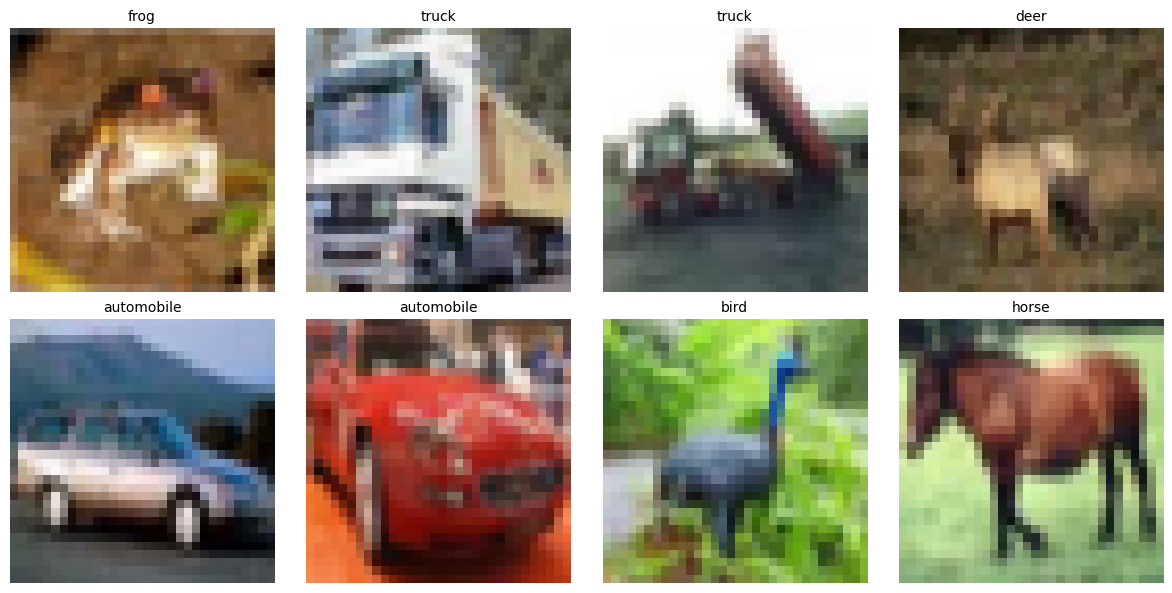

In [52]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations for dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),       # Convert images to PyTorch tensors
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Extract class labels
classes = dataset.classes  # CIFAR-10 has 10 classes

# Visualize a few images
def visualize_images(dataset, classes):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC format
        ax.set_title(classes[label], fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(dataset, classes)


In [55]:
import torch.nn as nn

class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, kernel_size=4, stride=2, padding=1),  # Add label channel
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed labels and expand to match image dimensions
        label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        label_emb = label_emb.expand(-1, -1, img.size(2), img.size(3))
        d_input = torch.cat((img, label_emb), dim=1)  # Concatenate label embedding with image
        return self.model(d_input)


In [56]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, img_channels, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * 32 * 32),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Embed labels and concatenate with noise
        label_emb = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_emb), dim=1)
        img_flat = self.model(gen_input)
        return img_flat.view(img_flat.size(0), 3, 32, 32)  # Reshape to RGB image


In [57]:
# Define noise dimensions and initialize the generator
noise_dim = 100
generator = ConditionalGenerator(noise_dim=noise_dim, img_channels=img_channels, num_classes=num_classes)


Files already downloaded and verified

Menu:
1. Generate a conditioned image
2. Quit
Enter your choice (1 or 2): 1

Available conditions:
0: Airplane
1: Automobile
2: Bird
3: Cat
4: Deer
5: Dog
6: Frog
7: Horse
8: Ship
9: Truck
Enter the number corresponding to your condition (0-9): 8


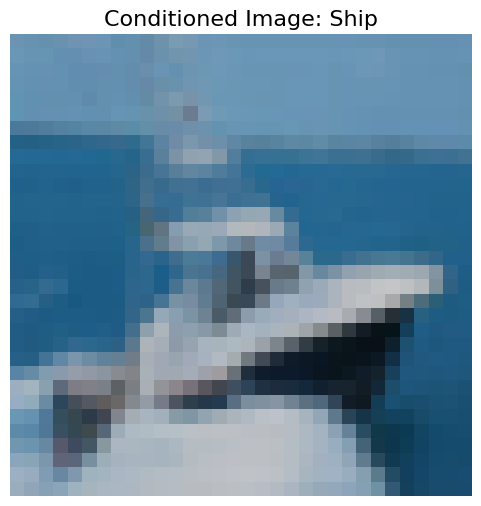


Menu:
1. Generate a conditioned image
2. Quit
Enter your choice (1 or 2): 2
Exiting the program. Goodbye!


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

# Define label names for CIFAR-10
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def generate_conditioned_image(label_index, dataset, label_names):
    """
    Generates a conditioned image by modifying colors of an image from CIFAR-10.
    Args:
        label_index (int): The index of the condition (e.g., 0 for Airplane, 1 for Automobile).
        dataset (Dataset): The CIFAR-10 dataset.
        label_names (list): List of label names corresponding to the dataset.
    Returns:
        numpy.ndarray: A conditioned color image (HWC format).
    """
    if label_index < 0 or label_index >= len(label_names):
        raise ValueError(f"Invalid condition index: {label_index}. Please enter a number between 0 and {len(label_names) - 1}.")

    # Select an image matching the condition
    for image, label in dataset:
        if label == label_index:
            # Convert the image to NumPy array for modification
            image_np = image.numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
            break

    # Ensure the image is in the range [0, 1] for valid transformations
    image_np = np.clip(image_np, 0, 1)

    # Apply condition-specific color modifications
    if label_index == 3:  # Cat
        image_np[:, :, 0] *= 1.5  # Enhance the red channel
    elif label_index == 1:  # Automobile
        image_np[:, :, 2] *= 1.5  # Enhance the blue channel
    elif label_index == 2:  # Bird
        image_np[:, :, 1] *= 1.5  # Enhance the green channel
    else:
        image_np *= 0.8  # Slightly dim images for other classes

    # Clip values to valid range [0, 1] after modifications
    image_np = np.clip(image_np, 0, 1)
    return image_np

def display_menu():
    """
    Displays the interactive menu.
    """
    print("\nMenu:")
    print("1. Generate a conditioned image")
    print("2. Quit")

def interactive_image_generation(dataset):
    """
    Interactive session for generating and visualizing conditioned images.
    """
    while True:
        display_menu()
        choice = input("Enter your choice (1 or 2): ").strip()

        if choice == '1':
            print("\nAvailable conditions:")
            for i, name in enumerate(label_names):
                print(f"{i}: {name}")
            user_input = input(f"Enter the number corresponding to your condition (0-{len(label_names) - 1}): ").strip()

            try:
                # Convert the input to an integer and generate the conditioned image
                label_index = int(user_input)
                conditioned_image = generate_conditioned_image(label_index, dataset, label_names)

                # Display the conditioned image
                plt.figure(figsize=(6, 6))
                plt.imshow(conditioned_image, interpolation='nearest')
                plt.title(f"Conditioned Image: {label_names[label_index]}", fontsize=16)
                plt.axis('off')
                plt.show()
            except ValueError as e:
                print(e)
        elif choice == '2':
            print("Exiting the program. Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")

# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Start the interactive session
interactive_image_generation(dataset)